In [1]:
import os, sys

import numpy  as np
import pandas as pd

from scipy import stats
from PIL   import Image, ImageFilter

import matplotlib.pyplot as plt

import generate_image_lists as giList

%matplotlib inline

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (14,10)

In [141]:
def arr_from_pil( inp_image ):
    channels = np.array( inp_image )
    r_ch = channels[:,:,0].reshape( inp_image.size[0], inp_image.size[1] )
    g_ch = channels[:,:,1].reshape( inp_image.size[0], inp_image.size[1] )
    b_ch = channels[:,:,2].reshape( inp_image.size[0], inp_image.size[1] )
    
    return np.swapaxes( np.swapaxes( np.array([r_ch,g_ch,b_ch]), 0, 2 ), 0, 1 )

# Simple resize and blurring of the image
def resize_blur(
                    inp_image              ,
                    size        = [512,512],
                    kernel_size =        5 ,
               ):
    
    # Read file if needed
    if   isinstance( inp_image, str ):
        if not os.path.exists( inp_image ):
            raise IOError( inp_image + ' is not a valid path to an image' )        
        raw_img = Image.open( inp_image )        
    elif isinstance( inp_image, Image.Image ):
        raw_img = inp_image
    else:
        raise TypeError('inp_image must be path to image or Pillow Image object')

    processed_img = raw_img.convert('RGBA')
        
    # Resizing image
    processed_img = processed_img.resize( size, Image.ANTIALIAS )

    # Blur the image
    # Do square kernel blurring
    processed_img = processed_img.filter( 
                                            ImageFilter.Kernel( 
                                                                [ kernel_size  ,
                                                                  kernel_size ], 
                                                              np.ones(kernel_size**2) 
                                                              ) 
                                        )

    img_arr = arr_from_pil( processed_img )
    return img_arr

def get_modes( 
                inp_arr ,
                drop_back
             ):
    count_dict = {}
    for     i in range( 0, inp_arr.shape[0] ):
        for j in range( 0, inp_arr.shape[1] ):
            
            my_key = inp_arr[i,j]
            if ( my_key in count_dict.keys() ):
                count_dict[ my_key ] = count_dict[ my_key ] + 1
            else:
                count_dict[ my_key ] = 0
    
    try:
        del count_dict[drop_back]
    except:
        pass
    
    ret_list = []
    
    # Got the count of values, now to sort
    for key, value in sorted( count_dict.iteritems(), key=lambda (k,v): (v,k)):
        ret_list.append( key )
#        print "%s: %s" % (key, value)
    return ret_list[-1]
    
    
# Pull out the color of the lego
#  and find indexes where the color is
#  present
def color_select( 
                    inp_arr,
                    n_color_groups =  6  ,
                    tolerance      = 10  ,
                    center_size    =  0.1,
                    display        = False,
                ):
    color_grouping = 255//n_color_groups
    
    # Get the image size
    img_size = inp_arr.shape[:2]
    
    img_arr_orig = inp_arr.copy()
    
    # Reduce the number of colors we are working with
    img_arr = img_arr_orig // color_grouping
    
    # Get the inner coordinates
    center_size  = [ int( img_size[0] * center_size ), int( img_size[1] * center_size ) ]
    center_coord = {
                    "x1": (img_size[0]-center_size[0])//2,
                    "x2": (img_size[0]+center_size[0])//2,
                    "y1": (img_size[1]-center_size[1])//2,
                    "y2": (img_size[1]+center_size[1])//2,
                   }

    
    center_img_arr = img_arr[center_coord['x1']:center_coord['x2'],center_coord['y1']:center_coord['y2'],:]
    
    # Get the channel average background
    chn_back_avg = []
    for i in range( 0, 3 ):
        chn_back_avg.append(
                            np.average(
                                        np.array(
                                                    [
                                                        img_arr[ 0, 0, i ],
                                                        img_arr[ 0,-1, i ],
                                                        img_arr[-1, 0, i ],
                                                        img_arr[-1,-1, i ],
                                                    ]
                                                )
                                      )
                           )
    
    mode_list = []
    # For each channel, get mode of 
    #  center color. Should be brick color
    for color in range( 0, 3 ):
        mode_list.append( color_grouping*get_modes( img_arr[:,:,color], chn_back_avg[color] ) )

    # Find where original colors within some tolerance of mode
    color_mask = (
                    ( img_arr_orig[:,:,0] > ( mode_list[0] - tolerance ) ) & 
                    ( img_arr_orig[:,:,0] < ( mode_list[0] + tolerance ) ) &
                    ( img_arr_orig[:,:,1] > ( mode_list[1] - tolerance ) ) & 
                    ( img_arr_orig[:,:,1] < ( mode_list[1] + tolerance ) ) &
                    ( img_arr_orig[:,:,2] > ( mode_list[2] - tolerance ) ) & 
                    ( img_arr_orig[:,:,2] < ( mode_list[2] + tolerance ) ) 
                 )
    
    if( display ):
        foo = np.where( color_mask, img_arr_orig[:,:,0], 0 )
        plt.imshow( img_arr * color_grouping )
        plt.show()
        plt.imshow( foo )
        plt.show()
    return color_mask

# Returns slope of lego
# Note this doesnt match picture, as y axis flipped
def lego_orientation(
                        inp_mask,
                    ):
    
    from sklearn.linear_model import LinearRegression
    
    # Mask is same for all channels,
    #  so can just use the x and y vals
    x_vals = []
    y_vals = []
    
    for     i in range( 0, inp_mask.shape[0] ):
        for j in range( 0, inp_mask.shape[1] ):
            
            if ( inp_mask[i,j] ):
                x_vals.append( i )
                y_vals.append( j )
    
    reg = LinearRegression()
    reg.fit( np.array(x_vals).reshape(-1,1), np.array(y_vals).reshape(-1,1) )

    return reg.coef_[0][0], reg.intercept_[0]

def reorient_lego(
                    inp_img,
                    slope,
                    intercept,
                    display = False,
                 ):
    
    angle   = np.arctan( -slope/2 ) * 360 / np.pi
    
    inp_img = Image.fromarray( inp_img, 'RGB' )
    
    rot_img = inp_img.rotate(-angle)
    
    rot_arr = arr_from_pil( rot_img )
    
    # Fill white
    rot_arr[
            ( rot_arr[:,:,0] == 0 ) & 
            ( rot_arr[:,:,1] == 0 ) & 
            ( rot_arr[:,:,2] == 0 ) 
           ] = 255
    
    
    if( display ):
        fig, ax = plt.subplots(1)
        ax.imshow( inp_img )
        ax.plot( range(0,inp_img.size[0]), np.arange(0,inp_img.size[0])*slope+intercept)
        plt.show()
        
        plt.imshow(rot_arr)
        plt.show()
    
    return rot_arr

# Get the edge features from images
def locate_edges(
                    inp_arr,
                    square  = False,
                    display = False,
                ):
    
    # Change to image
    inp_img  = Image.fromarray( inp_arr, 'RGB' )
    
    # Locate edges
    edge_img =  inp_img.filter(ImageFilter.FIND_EDGES)
    
    # Convert to np array
    edge_arr = arr_from_pil( edge_img )

    # Average pixel values
    if ( square ):
        grey_edge_arr = np.sqrt( np.sum( edge_arr**2, axis=2 ) ) / 3
    else:
        grey_edge_arr =          np.sum( edge_arr , axis=2 )
        
    if ( display ):
        plt.imshow( grey_edge_arr )
        plt.show()
        
    return grey_edge_arr

# Engineer features from the edges
def get_edge_features(
                        inp_arr,
                        display = False,
                     ):
    
    # Get the sum of rows and columns
    # Ignore very edges
    inp_arr_row = np.sum( inp_arr[1:-1,1:-1], axis=1 )
    inp_arr_col = np.sum( inp_arr[1:-1,1:-1], axis=0 )

    # Normalizations
    row_norm    = np.average( inp_arr_row )
    col_norm    = np.average( inp_arr_col )

    # Do normalization
    inp_arr_row = inp_arr_row / row_norm
    inp_arr_col = inp_arr_col / col_norm

    if ( display ):
        plt.plot( range(0,inp_arr_col.shape[0]), inp_arr_col )
        plt.title('Col')
        plt.show()

        plt.plot( range(0,inp_arr_row.shape[0]), inp_arr_row )
        plt.title('Row')
        plt.show()

In [139]:
img_list, label_list = giList.get_white_images_labels()

In [143]:
plt.rcParams['figure.figsize'] = (4,4)

In [147]:
len(img_list)

284

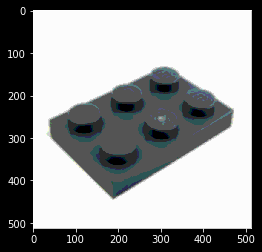

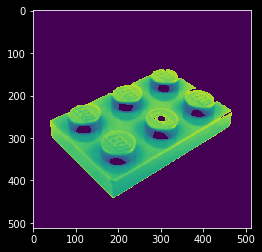

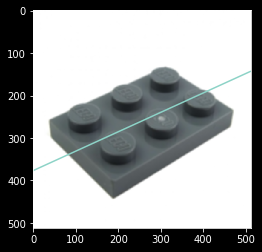

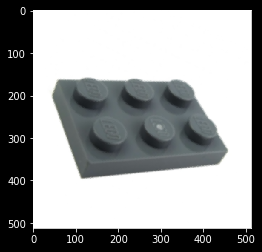

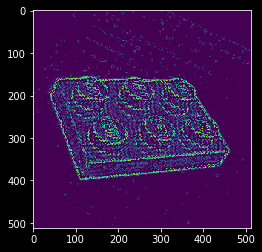

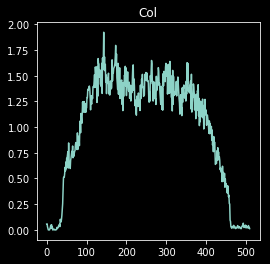

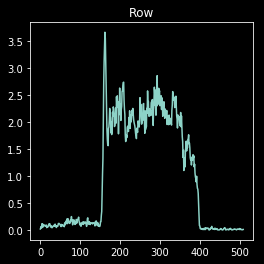

In [146]:
#i    = 22
disp = True

for i in range( 0, len(img_list) , 10):
    # Smooth the image
    pp_img_arr = resize_blur( img_list[i] )

    # Get indexes containing lego
    color_mask = color_select( 
                                    pp_img_arr,
                                    n_color_groups =  6  ,
                                    tolerance      = 50  ,
                                    center_size    =  0.1,
                                    display=disp
                             )

    # Inclination, and axis intercept, of lego image
    slope, intercept = lego_orientation( color_mask )

    # Rotate so lego horizontal
    rot_arr = reorient_lego( pp_img_arr, slope, intercept, display=disp )

    # Get the edges
    edge_arr = locate_edges( rot_arr, square=True, display=disp )

    get_edge_features( edge_arr, display=disp )
    
    print '\n\n\n\n\n\n'

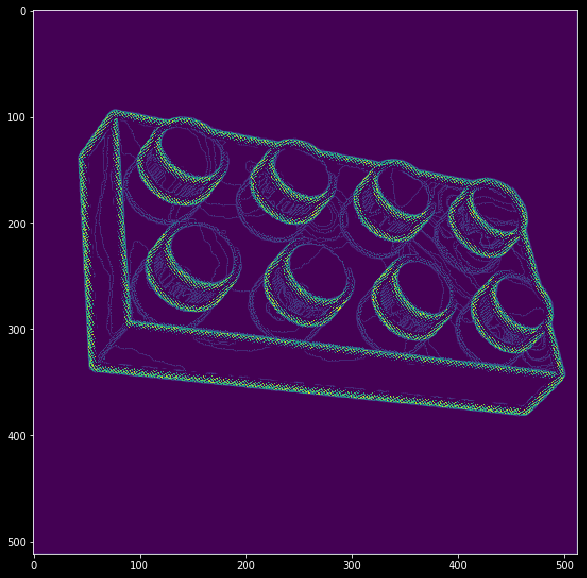

In [121]:
edge_arr = locate_edges( rot_arr, square=True )

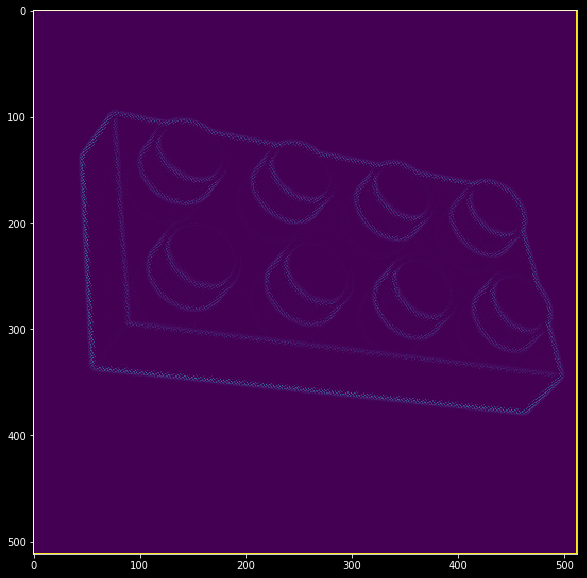

In [120]:
edge_arr = locate_edges( rot_arr )

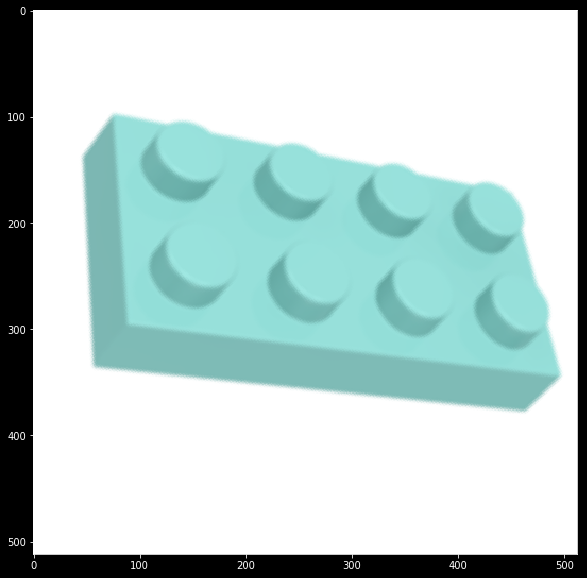

In [57]:
reorient_lego( pp_img_arr, slope, intercept )

433.3251655370323


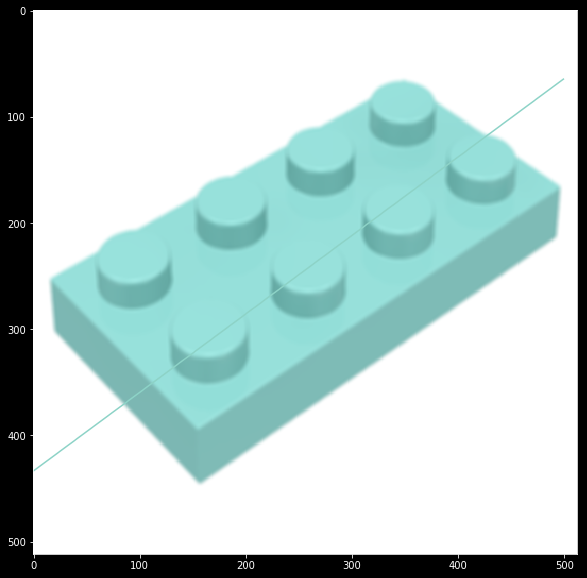

In [15]:
# Generate orientation of the lego
fig, ax = plt.subplots(1)
ax.imshow(pp_img)
xx = np.arange( 0, 500 )
ax.plot( xx, xx*slope+intercept )
plt.show()

(512, 512)
(512, 512, 3)
(512, 512)


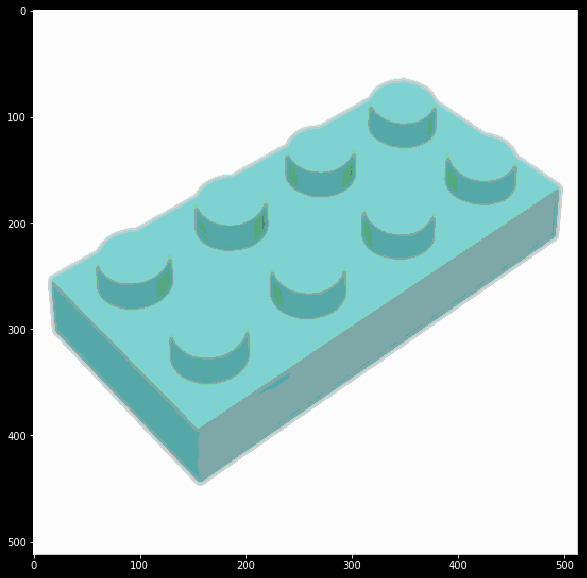

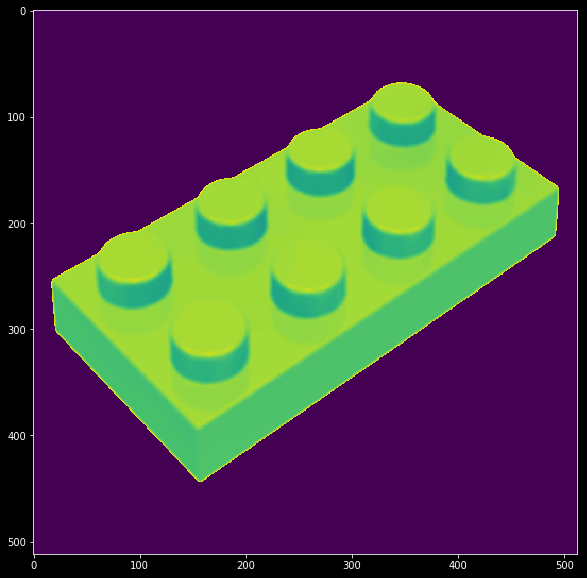

In [196]:
color_select( 
                pp_img,
                n_color_groups =  6  ,
                tolerance      = 50  ,
                center_size    =  0.1,
            )

(512, 512, 3)


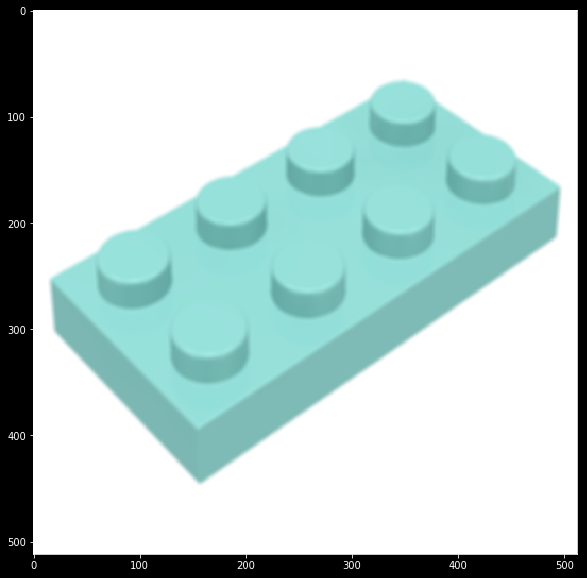

In [199]:
print pp_img.shape
plt.imshow( pp_img )